In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob

In [2]:
GRID_H = 9
GRID_W = 6

In [3]:
with open("cameraCal.npy", "rb") as f:
    mtx = np.load(f)
    dist = np.load(f)

class undistort:
    def __init__(self, mtx, dist):
        self.mtx = mtx
        self.dist = dist

    def undistort(self, img):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (w,h), 1, (w,h))

        dst = cv2.undistort(img, self.mtx, self.dist, None, newcameramtx)

        return dst

UDT = undistort(mtx, dist)

In [4]:
def get_length(p1, p2):
    return np.sqrt( (p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

In [5]:
images = glob.glob('distance/*.jpg')
images.sort()

distance = 300 # mm
distance_increment = 100
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

FRST_P = 0
SCND_P = 8
LENGTH = 22 * (SCND_P - FRST_P) # mm

lengths = []
distances = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])

        lengths.append(length)
        distances.append(distance)

        distance += distance_increment


Text(0, 0.5, '1/Distance')

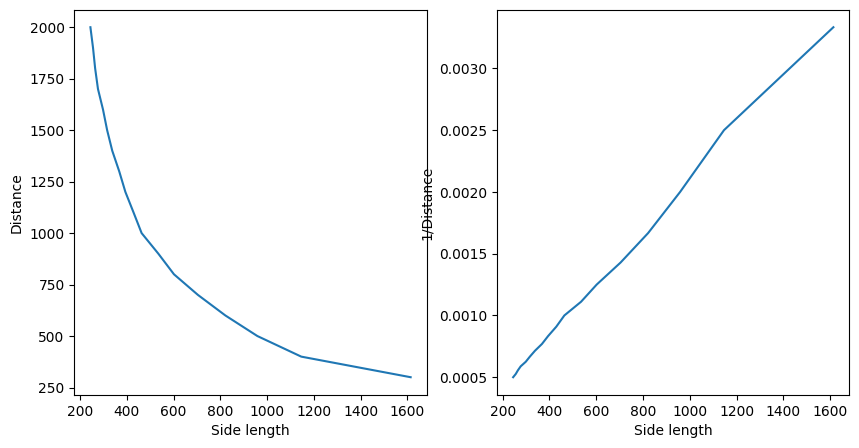

In [6]:
distances2 = [1/x for x in distances]

plt.figure(figsize=(10, 5))  # Set the figure size

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(lengths, distances)
plt.xlabel("Side length")
plt.ylabel("Distance")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(lengths, distances2)
plt.xlabel("Side length")
plt.ylabel("1/Distance")


As expected from the perspective model, the correlation between length of one side and distance is linear

In [7]:
lengths[:5], distances[:5]

([1613.5954822143494,
  1145.9753545320832,
  958.4165269529692,
  821.4850277031497,
  704.000936654387],
 [300, 400, 500, 600, 700])

In [8]:
class DistanceEstimator:
    def __init__(self, lengths, inv_distances):
        self.m, self.b = np.polyfit(lengths, inv_distances, 1)
    
    def get_distance(self, length):
        return 1 / (self.m * length + self.b)

DE = DistanceEstimator(lengths, distances2)
DE.get_distance(lengths[0])

296.73791223826083

In [9]:
def put_text(img, text, offset=0):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (2000, 500 + offset)
    fontScale = 10
    color = (255, 0, 0)
    thickness = 20
    img = cv2.putText(img, text, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    return img

In [10]:
objp = np.zeros((GRID_H*GRID_W,3), np.float32)
objp[:,:2] = np.mgrid[0:GRID_H,0:GRID_W].T.reshape(-1,2)

In [11]:
imgs = []
estimated_distances = []
nums = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (22,22), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])
        distance = DE.get_distance(length)
        estimated_distances.append(distance)
        distance = int(distance*10)
        distance /= 10

        img = put_text(img, str(distance))

        imgs.append(img)


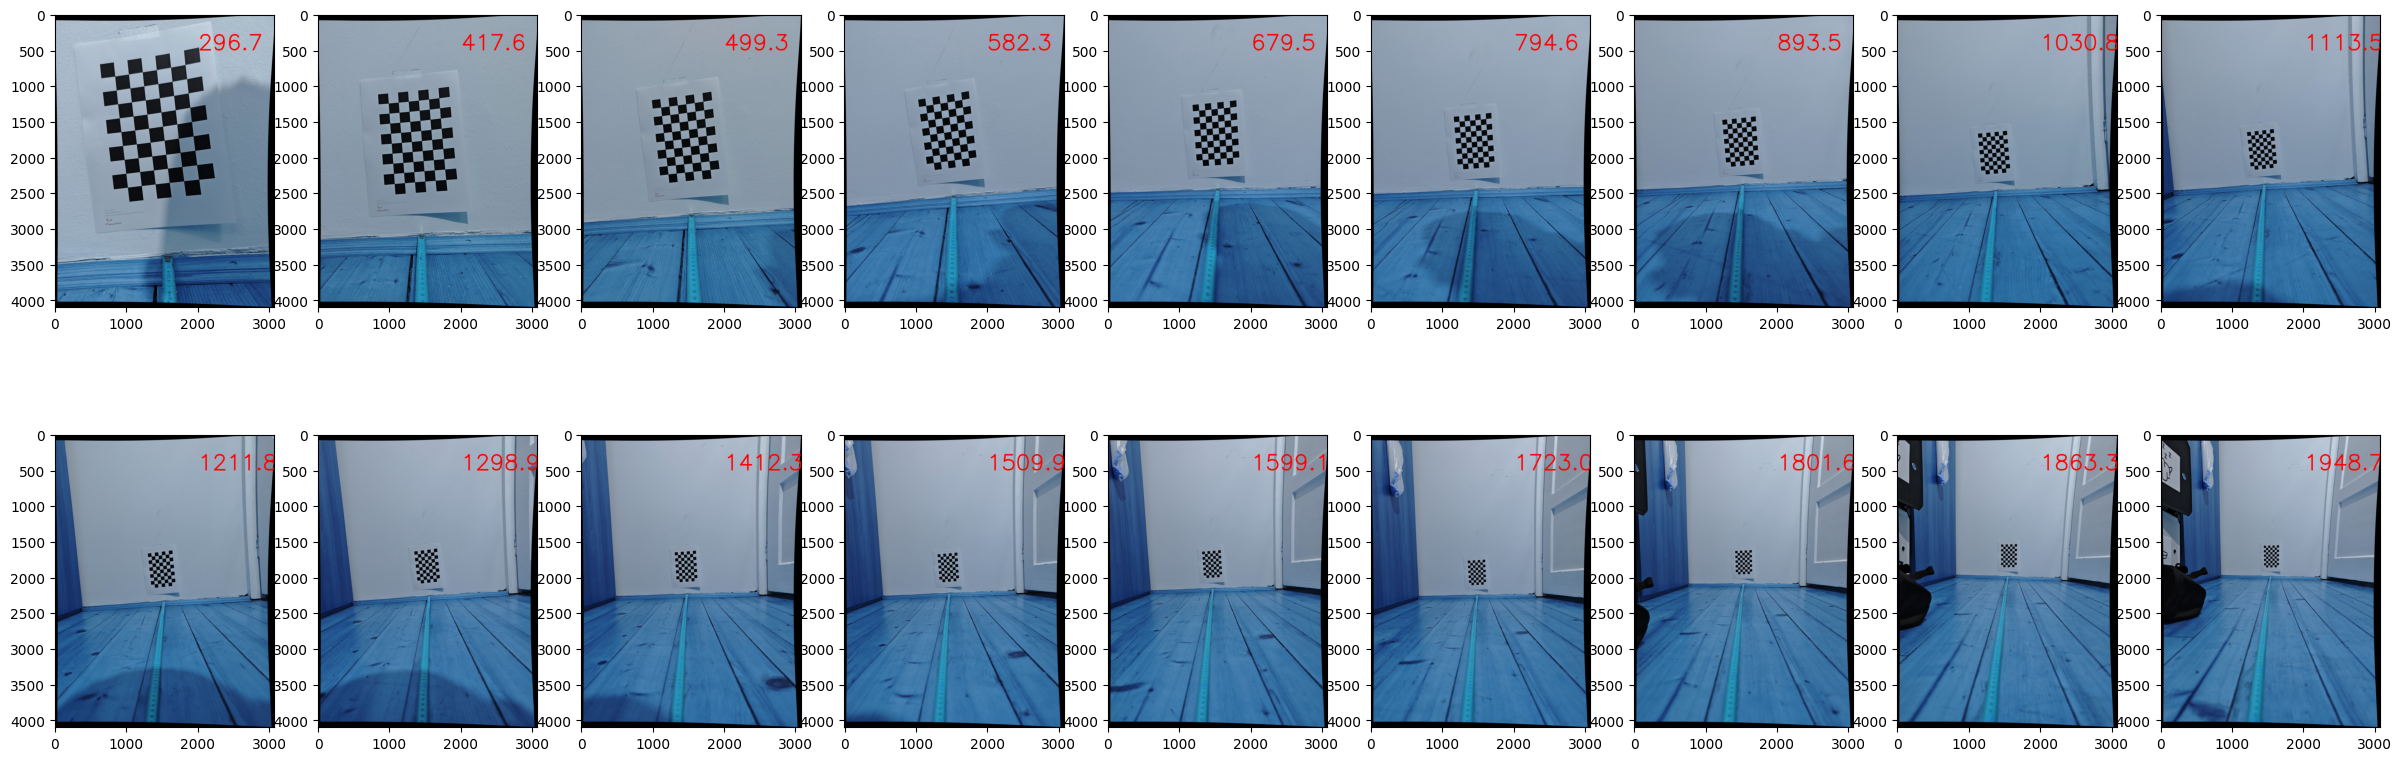

In [12]:
plt.figure(figsize=(30, 10))  # Set the figure size
i = 1

for img in imgs:
    plt.subplot(2, 9, i)

    plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    i += 1

14.692746208082553


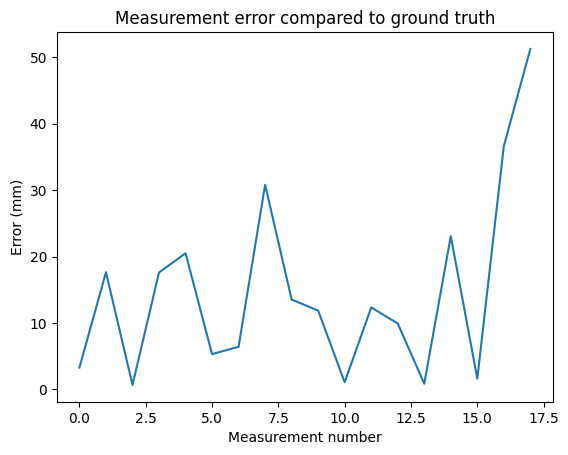

In [13]:
errors = []
distances_actual = []
distance = 300 # mm
distance_increment = 100
while distance < 2001:
    distances_actual.append(distance)
    distance += distance_increment

for i in range(len(distances)):
    error = abs(distances_actual[i] - estimated_distances[i])
    errors.append(error)

print(np.average(errors))

plt.title("Measurement error compared to ground truth")
plt.xlabel("Measurement number")
plt.ylabel("Error (mm)")
plt.plot(errors)

In [14]:
objp = np.zeros((GRID_H*GRID_W,3), np.float32)
objp[:,:2] = np.mgrid[0:GRID_H,0:GRID_W].T.reshape(-1,2)

In [15]:
mtx

array([[2.96847690e+03, 0.00000000e+00, 1.48721349e+03],
       [0.00000000e+00, 3.00689340e+03, 2.07348945e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [16]:
imgs = []
estimated_distances = []

distances_1 = []
distances_2 = []

for fname in images:
    img = cv2.imread(fname)
    #img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (22,22), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])
        distance = DE.get_distance(length)
        estimated_distances.append(distance)
        distance = int(distance*10)
        distance /= 10

        img = put_text(img, str(distance))

        #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objp], [corners2], gray.shape[::-1], None, None)
        #print(tvecs)
        ret, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)
        # print(tvec)
        # tvec is the translation vector that represents the position of the checkerboard in the camera's coordinate system.
        # The magnitude of tvec gives the distance from the camera to the checkerboard center.
        distance2 = np.linalg.norm(tvec)
        print(distance, distance2, distance2/distance)
        distance2 /= 0.05
        distance2 = int(distance2*10)
        distance2 /= 10

        distances_1.append(distance)
        distances_2.append(distance2)

        img = put_text(img, str(distance2), 400)

        imgs.append(img)


284.9 15.759065070691086 0.05531437371249943
396.5 20.924348333565653 0.05277263135829925
474.3 24.77812658375312 0.05224146443970719
553.8 28.905988384432003 0.05219571755946552
646.0 33.45340284646743 0.051785453322705
752.4 38.55944089166917 0.051248592360006874
846.3 43.23407002071695 0.05108598608143324
971.2 49.2980473482668 0.050759933431081955
1050.3 53.32539646022339 0.050771585699536693
1144.4 58.05258193949855 0.05072752703556322
1227.6 61.860724932328836 0.05039159737074685
1334.2 67.14021001357762 0.05032244791903584
1425.0 71.75218352898382 0.05035240949402373
1511.4 76.3751276394308 0.050532703215185125
1625.0 81.49688696782252 0.050151930441736936
1705.5 85.77933445176623 0.05029571061375915
1768.6 89.68333043267785 0.05070865680915857
1848.2 93.92931123102663 0.05082204914566964


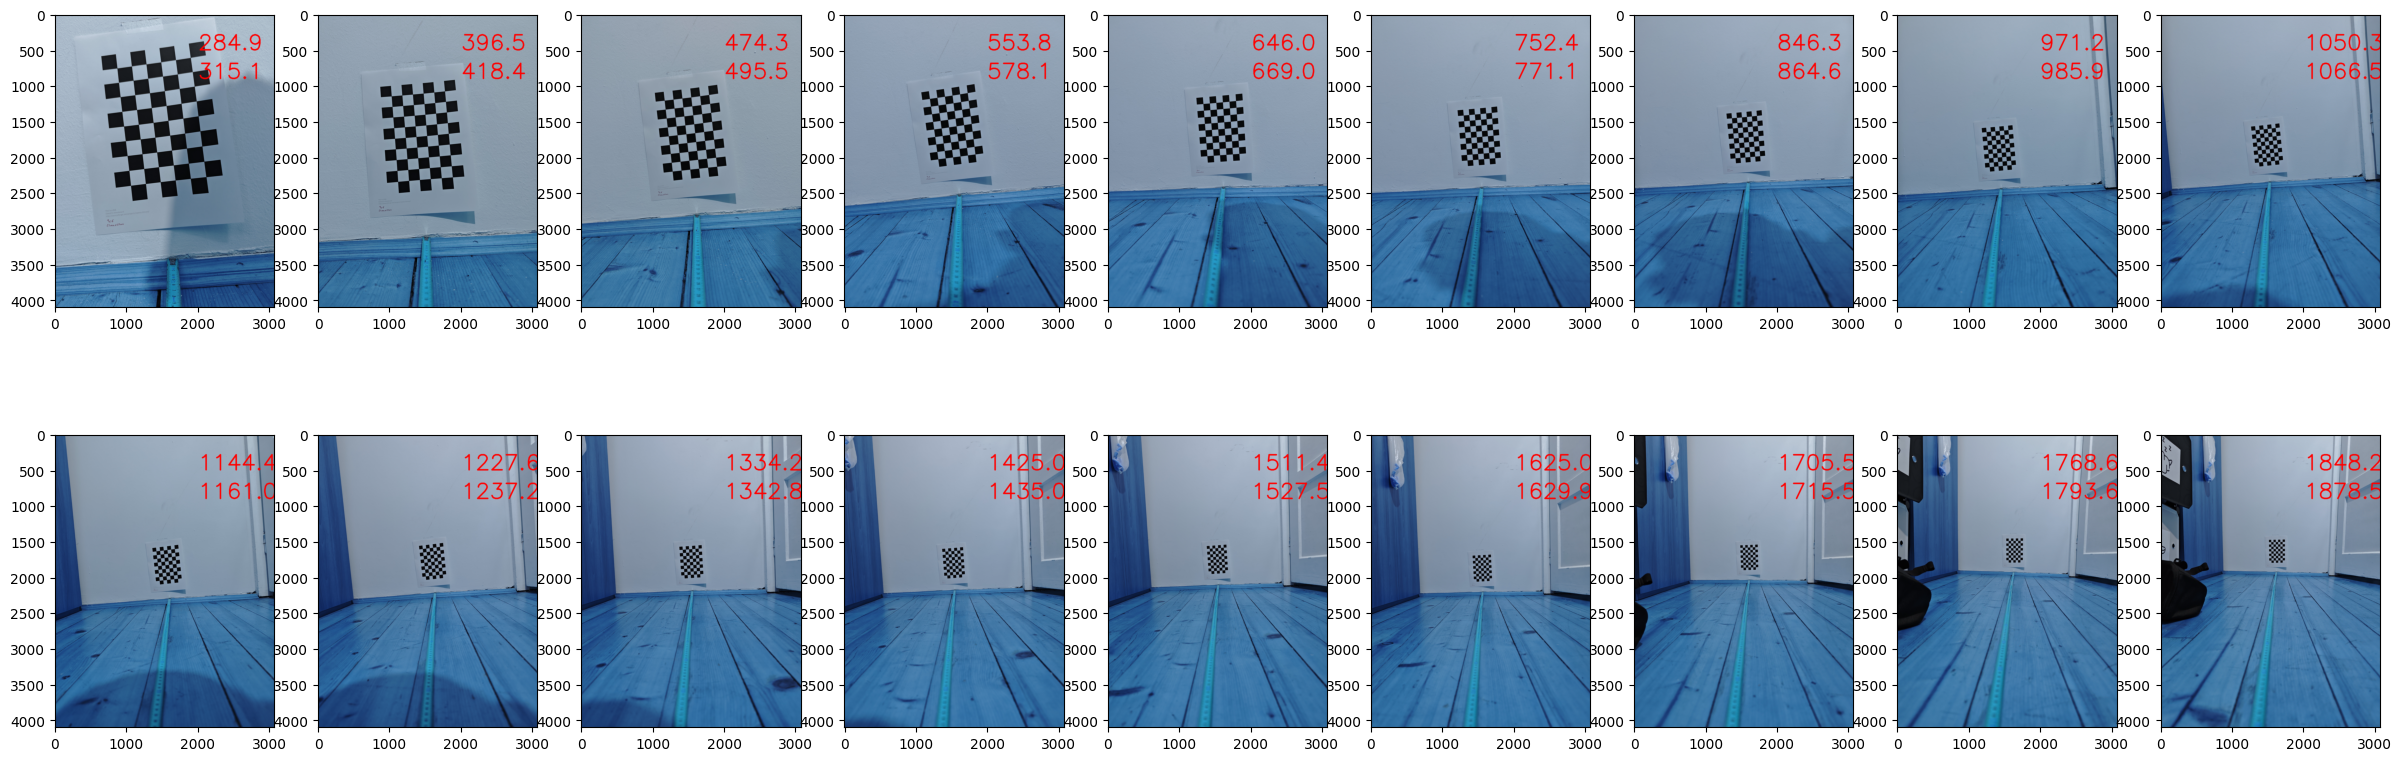

In [17]:
plt.figure(figsize=(30, 10))  # Set the figure size
i = 1

for img in imgs:
    plt.subplot(2, 9, i)

    plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    i += 1

[[ 2.17629992]
 [-7.69548781]
 [ 9.61827091]]
[[ 1.9666702 ]
 [-6.97366791]
 [14.5871403 ]]
284.9 16.287556534931706 0.0571693806069909


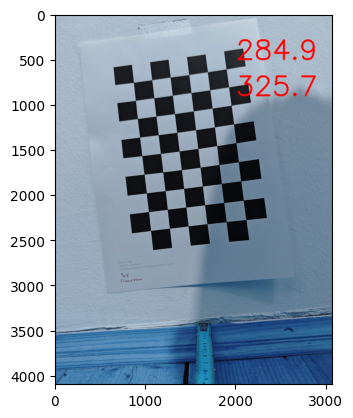

In [18]:
fname = images[0]
img = cv2.imread(fname)
#img = UDT.undistort(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

if ret:
    corners2 = cv2.cornerSubPix(gray,corners, (22,22), (-1,-1), criteria)

    length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])
    distance = DE.get_distance(length)
    estimated_distances.append(distance)
    distance = int(distance*10)
    distance /= 10

    img = put_text(img, str(distance))

    _, _, dist, rvecs, tvecs = cv2.calibrateCamera([objp], [corners2], gray.shape[::-1], None, None)
    print(tvecs[0])
    ret, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)
    print(tvec)
    
    # tvec is the translation vector that represents the position of the checkerboard in the camera's coordinate system.
    # The magnitude of tvec gives the distance from the camera to the checkerboard center.
    distance2 = np.linalg.norm(tvec)
    print(distance, distance2, distance2/distance)
    distance2 /= 0.05
    distance2 = int(distance2*10)
    distance2 /= 10

    img = put_text(img, str(distance2), 400)

    plt.imshow(img)

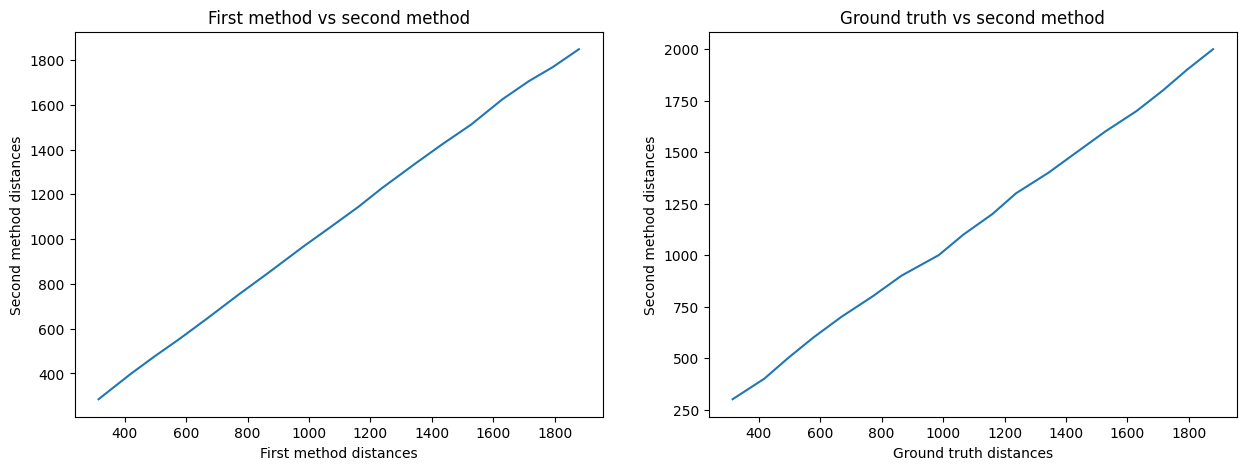

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.title("First method vs second method")
plt.xlabel("First method distances")
plt.ylabel("Second method distances")
plt.plot(distances_2, distances_1)


plt.subplot(1,2,2)

plt.title("Ground truth vs second method")
plt.xlabel("Ground truth distances")
plt.ylabel("Second method distances")
plt.plot(distances_2, np.array([300 + i*100 for i in range(18)]))

In [20]:
distances_gt = [300 + i*100 for i in range(18)]

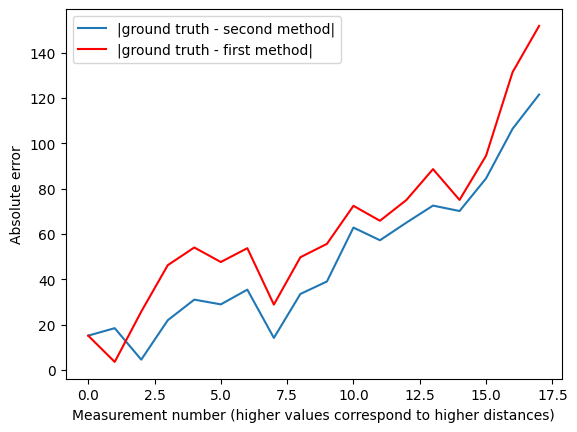

In [21]:
errors = [abs(distances_gt[i] - distances_2[i]) for i in range(len(distances_1))]
plt.plot(errors, label="|ground truth - second method|")

plt.ylabel("Absolute error")
plt.xlabel("Measurement number (higher values correspond to higher distances)")

plt.plot([abs(distances_gt[i] - distances_1[i]) for i in range(len(distances_1))], color='red', label="|ground truth - first method|")

plt.legend()